In [1]:
# Fangjun Hu

import numpy as np
from numpy.random import randn as randn
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import torchvision
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import transforms as trns
import torch
import torch.nn as nn
import torch.optim as optim
from schedulefree.adamw_schedulefree import AdamWScheduleFree
from pytorch_msssim import ssim
from PIL import Image
from tqdm import tqdm, trange
import torch.nn.functional as F
import os
import random
import math

import time

from unet_model import UNet
from unet_model import build_xy_coordinates, sinusoidal_2d
device = "cuda"

In [2]:
# Import our improved model
from improved_enhanced_cnn import (
    ImprovedCNNAutoencoder, 
    create_local_model, 
    create_global_model,
    HybridLoss,
    ProgressiveLoss
)

# 1. Partial Global Denoising 

In [3]:
pos_emb_dim = 16
xs, ys = build_xy_coordinates(28, 28)
pos = sinusoidal_2d(xs, ys, dim=pos_emb_dim).to(device)

In [4]:
rng_state = torch.get_rng_state()

def test_partial_global(pred_x, model_global, gen_with_cond=False, beta_i=0, beta_f=1, T=32, IMAGE_COUNT=256):

    with torch.no_grad():
        
        cond = torch.arange(IMAGE_COUNT).long().to(device) % 10
        t = torch.ones(IMAGE_COUNT,).to(device) * beta_f
        pos_exp = pos.expand(IMAGE_COUNT, -1, -1, -1) 
        
        STEPS = math.ceil((beta_f - beta_i)*T)

        print(STEPS)
        
        for i in range(STEPS):
            pred_emb = torch.cat([pred_x, pos_exp], dim=1)
            
            # Global diffusion
            pred = model_global(pred_emb, t, cond = cond if gen_with_cond else None)
            pred_x = pred_x + pred * ((beta_f - beta_i) / STEPS)
            t = t - ((beta_f - beta_i) / STEPS)
    
    return pred_x
            

In [6]:
CLASSES = None
T = 32

global_beta_i = 0
global_beta_f = 1

# transform = trns.Compose([trns.ToTensor(), trns.Normalize((0.5,), (0.5,))])
transform = trns.Compose([trns.ToTensor(), ])
dataset = MNIST("./data", download=False, transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=512,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True,
)

model_global = UNet(in_channels=1 + pos_emb_dim*2, out_channels=1, emb_dim = 512, num_classes=CLASSES).to(device)
model_global.load_state_dict(torch.load("./model-gen/mnist-gen-global.pth", map_location=device))
model_global.eval()

torch.manual_seed(0)
images = torch.randn(256, 1, 28, 28).to(device)

pred_x = test_partial_global(images, model_global, gen_with_cond=False, beta_i=global_beta_i, beta_f=global_beta_f, T=32)

<ipython-input-6-6e7ff0e9cf5f>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_global.load_state_dict(torch.load("./model-gen/mnist-gen-global.pth", map_location=dev

32


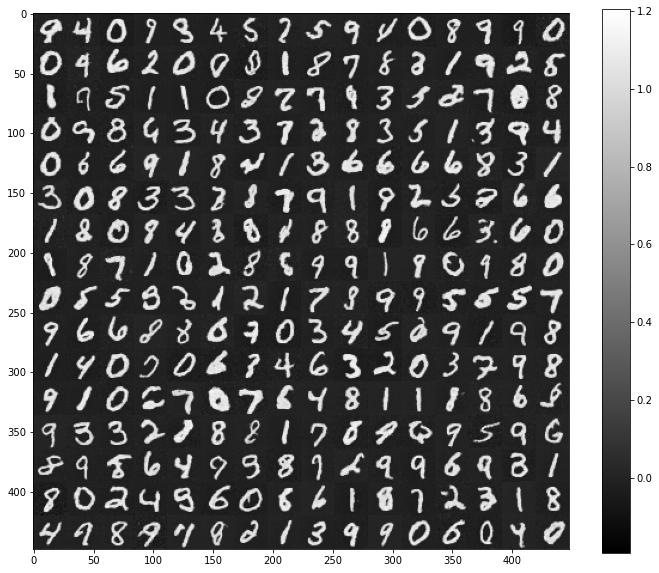

In [7]:
pred_img = pred_x.reshape(16, 16, 28, 28).permute(0, 2, 1, 3)
pred_img = pred_img.reshape(16 * 28, 16 * 28).cpu().numpy()#.clip(0, 1)

plt.figure(figsize=(12, 10))
im = plt.imshow(pred_img, cmap='gray')
plt.colorbar(im)

# 2. Prerequisite for Local Denoisers in Data Phase Side

In [8]:
# Training parameters
TF_TEST = 0.3  # Standard test noise level
TF_HIGH = 1.0  # High noise level (pure noise)
R_TEST = 2     # Receptive field radius

# Model parameters
EMB_DIM = 64
BASE_CHANNELS = 16
BATCH_SIZE = 256  # Smaller for more stable training
EPOCHS = 15
LR = 0.0005  # Lower learning rate for better convergence

In [9]:
# Create both local and global models
local_model = create_local_model(
    receptive_field_radius=R_TEST,
    emb_dim=EMB_DIM,
    base_channels=BASE_CHANNELS
).to(device)

global_model = create_global_model(
    receptive_field_radius=R_TEST,
    emb_dim=EMB_DIM,
    base_channels=BASE_CHANNELS
).to(device)

local_params = sum(p.numel() for p in local_model.parameters())
global_params = sum(p.numel() for p in global_model.parameters())

print(f"\nLocal model (R_INTERNAL=0):  {local_params:,} parameters")
print(f"Global model (R_INTERNAL=1): {global_params:,} parameters")
print(f"Difference: {global_params - local_params:,} parameters")

# Test forward pass
print(f"\nTesting forward pass...")
test_input = torch.randn(2, 1, 28, 28).to(device)
test_t = torch.tensor([0.3, 1.0]).to(device)

with torch.no_grad():
    local_output = local_model(test_input, test_t)
    global_output = global_model(test_input, test_t)
    
print(f"Local model output: {local_output.shape}")
print(f"Global model output: {global_output.shape}")

Creating LOCAL model (R_INTERNAL=0)
Model created: 276,881 parameters
Creating GLOBAL model (R_INTERNAL=3)
Model created: 7,714,388 parameters

Local model (R_INTERNAL=0):  276,881 parameters
Global model (R_INTERNAL=1): 7,714,388 parameters
Difference: 7,437,507 parameters

Testing forward pass...
Local model output: torch.Size([2, 1, 28, 28])
Global model output: torch.Size([2, 1, 28, 28])


In [10]:
# Load MNIST dataset
transform = trns.Compose([
    trns.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=False, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=False, transform=transform
)

# Split training set
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset loaded:")
print(f"  Training: {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

Dataset loaded:
  Training: 48000 samples
  Validation: 12000 samples
  Test: 10000 samples


In [14]:
# Utility functions
def linear_interpolate_to_noise(images, tf):
    """Linearly interpolate between images and noise based on tf"""
    noise = torch.randn_like(images)
    return (1 - tf) * images + tf * noise

def create_coordinate_channels(batch_size, height, width, device):
    """Create x and y coordinate channels normalized between -1 and 1"""
    y_coords = torch.linspace(-1, 1, height).view(1, 1, height, 1).expand(batch_size, 1, height, width)
    x_coords = torch.linspace(-1, 1, width).view(1, 1, 1, width).expand(batch_size, 1, height, width)
    return x_coords.to(device), y_coords.to(device)

def create_time_channel(batch_size, height, width, tf_values, device):
    """Create time channel with tf values (0 to 1) for each image"""
    time_channel = tf_values.view(batch_size, 1, 1, 1).expand(batch_size, 1, height, width)
    return time_channel.to(device)

def prepare_input_with_coords_and_time(images, tf_values):
    """Combine MNIST images with coordinate and time channels (legacy format)"""
    batch_size, _, height, width = images.shape
    x_coords, y_coords = create_coordinate_channels(batch_size, height, width, images.device)
    time_channel = create_time_channel(batch_size, height, width, tf_values, images.device)
    return torch.cat([images, x_coords, y_coords, time_channel], dim=1)

In [15]:
class CurriculumScheduler:
    """Curriculum learning scheduler that gradually increases noise difficulty."""
    
    def __init__(self, total_epochs: int, start_tf: float = 0.1, end_tf: float = 1.0,
                 warmup_epochs: int = 5):
        self.total_epochs = total_epochs
        self.start_tf = start_tf
        self.end_tf = end_tf
        self.warmup_epochs = warmup_epochs
        
    def get_noise_range(self, epoch: int):
        """Get the noise range for current epoch."""
        if epoch < self.warmup_epochs:
            # Warmup: only use low noise
            max_tf = self.start_tf + (0.3 - self.start_tf) * (epoch / self.warmup_epochs)
            return self.start_tf, max_tf
        else:
            # Progressive: gradually increase max noise
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            max_tf = 0.3 + (self.end_tf - 0.3) * progress
            return self.start_tf, min(max_tf, self.end_tf)
    
    def sample_noise_levels(self, batch_size: int, epoch: int, device) -> torch.Tensor:
        """Sample noise levels for current epoch."""
        min_tf, max_tf = self.get_noise_range(epoch)
        
        # Sample uniformly in the allowed range
        tf_values = torch.rand(batch_size, device=device) * (max_tf - min_tf) + min_tf
        return tf_values

# Create curriculum schedulers
curriculum_scheduler = CurriculumScheduler(total_epochs=EPOCHS, warmup_epochs=3)

print("Curriculum scheduler created")
print("Noise level progression:")
for epoch in [0, 2, 5, 10, 15, 19]:
    min_tf, max_tf = curriculum_scheduler.get_noise_range(epoch)
    print(f"  Epoch {epoch:2d}: TF range [{min_tf:.2f}, {max_tf:.2f}]")

Curriculum scheduler created
Noise level progression:
  Epoch  0: TF range [0.10, 0.10]
  Epoch  2: TF range [0.10, 0.23]
  Epoch  5: TF range [0.10, 0.42]
  Epoch 10: TF range [0.10, 0.71]
  Epoch 15: TF range [0.10, 1.00]
  Epoch 19: TF range [0.10, 1.00]


In [21]:
def euler_generation(model, noisy_images, start_tf=1.0, end_tf=0.0, num_steps=100):
    """
    Euler method generation: uses small time steps dt and subtracts dt*noise at each step.
    
    Based on the differential equation formulation:
    dx/dt = -noise_prediction(x, t)
    
    Args:
        model: Trained noise prediction model
        noisy_images: Initial noisy images 
        start_tf: Starting noise level (1.0 = pure noise, 0.0 = clean)
        end_tf: Target noise level (usually 0.0 for clean images)
        num_steps: Number of small Euler steps
    
    Returns:
        denoised_images: Final denoised images
        intermediate_images: List of images at each step
    """
    model.eval()
    device = noisy_images.device
    batch_size = noisy_images.size(0)
    
    # Calculate step size
    dt = (start_tf - end_tf) / num_steps
    
    current_images = noisy_images.clone()
    current_t = start_tf
    intermediate_images = [current_images.clone()]
    
    print(f"Euler Generation: {num_steps} steps with dt={dt:.4f} from TF={start_tf:.2f} to TF={end_tf:.2f}")
    
    with torch.no_grad():
        pbar = tqdm(range(num_steps), desc="Euler Steps")
        for i in pbar:
            # Create current timestep tensor
            t_tensor = torch.full((batch_size,), current_t, device=device)
            
            # Predict noise at current timestep and current image
            predicted_noise = model(current_images, t_tensor, noise_level=t_tensor)
            
            # Euler step: x_{t+dt} = x_t - dt * noise_prediction(x_t, t)
            # This moves us in the direction of reducing noise
            current_images = current_images - dt * predicted_noise
            
            # Update time
            current_t = current_t - dt
            
            # Clamp to valid image range
            current_images = torch.clamp(current_images, 0.0, 1.0)
            
            # Store intermediate result every few steps
            if i % max(1, num_steps // 10) == 0 or i == num_steps - 1:
                intermediate_images.append(current_images.clone())
            
            # Update progress bar
            pbar.set_postfix({
                'TF': f'{current_t:.3f}',
                'Noise_std': f'{predicted_noise.std():.3f}',
                'Img_range': f'[{current_images.min():.2f}, {current_images.max():.2f}]'
            })
    
    print(f"Euler generation completed!")
    return current_images, intermediate_images

# 3. Generation of Images whit Local Denoisers within Different Time-Interval

In [22]:
radius_scan_dir = "./model-gen/"

R_INTERNAL_LIST_RANGE = [[0,0,0],[1,0,0],[1,0,0],[1,1,0],[1,1,0],[1,1,1],[1,1,1],[2,1,1],[2,1,1],[2,2,1],[2,2,1],[2,2,2]]

r_test    = 3
r_idx     = r_test - 1
r_initial = r_test % 2

t_up = 0.5
t_dn = 0.2

## 3.1 Local denoisers for $t \notin [0.2, 0.5]$, global denoisers for $t \in [0.2, 0.5]$

<ipython-input-23-a42e35c5c74b>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Creating LOCAL model (R_INTERNAL=0)
Model created: 297,105 parameters
Loaded model R3 from ./model-gen/local_model_internal_R3.pth
Euler Generation: 16 steps with dt=0.0312 from TF=1.00 to TF=0.50


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 31.91it/s, TF=0.500, Noise_std=0.476, Img_range=[0.00, 0.59]]


Euler generation completed!
10
Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 21.61it/s, TF=-0.000, Noise_std=0.351, Img_range=[0.00, 0.97]]


Euler generation completed!


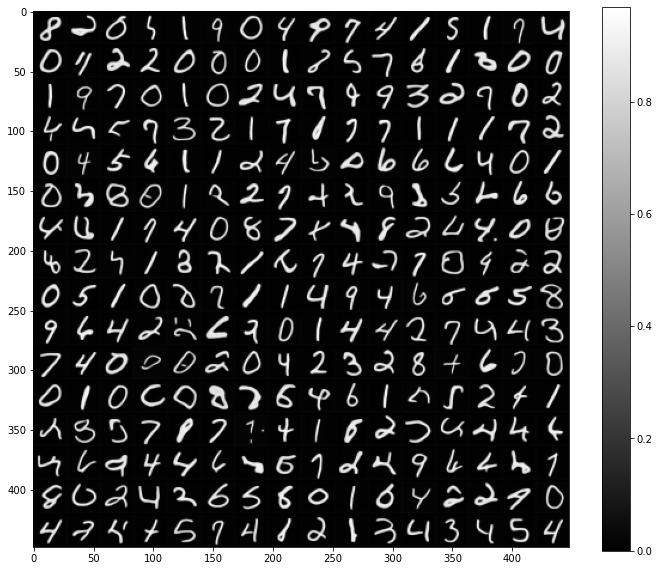

In [23]:
# Fix random seed for reproducible test images
torch.manual_seed(42)
np.random.seed(42)

# # Get fixed test images from test dataset
IMAGE_COUNT = 16 * 16
torch.manual_seed(0)
images_seeds = torch.randn(256, 1, 28, 28).to(device)
    
# Load the trained model
model_path = os.path.join(radius_scan_dir, f'local_model_internal_R{r_test}.pth')

# Create model architecture
test_model = create_local_model(
receptive_field_radius=r_initial,
conv1_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][0],
conv2_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][1],
conv3_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][2],
emb_dim=EMB_DIM,
base_channels=BASE_CHANNELS,
).to(device)

# Load trained weights
checkpoint = torch.load(model_path, map_location=device)
test_model.load_state_dict(checkpoint['model_state_dict'])
test_model.eval()

print(f"Loaded model R{r_test} from {model_path}")

########################
### Phase 0
########################

noisy_images = images_seeds.clone()

########################
### Phase 1
########################

noisy_images, _ = euler_generation(test_model, noisy_images, 1., t_up, math.ceil((1-t_up)*32))

########################
### Phase 2
########################

# Global Denoisers
noisy_images = test_partial_global(noisy_images, model_global, gen_with_cond=False, beta_i=t_dn, beta_f=t_up, T=32, IMAGE_COUNT=IMAGE_COUNT)

########################
### Phase 3
########################

# Local Denoisers
noisy_images, _ = euler_generation(test_model, noisy_images, t_dn, 0., math.ceil((t_dn - 0)*32))
                
# Convert to 16x16 grid visualization
grid_images = noisy_images[:256].reshape(16, 16, 28, 28).permute(0, 2, 1, 3).reshape(16 * 28, 16 * 28).cpu().numpy()
plt.figure(figsize=(12, 10))
im = plt.imshow(grid_images, cmap='gray')
plt.colorbar(im)

noisy_images_local_global_local = noisy_images.clone()


## 3.2 Local denoisers for $t \in [0.2, 0.5]$, global denoisers for $t \notin [0.2, 0.5]$

Creating LOCAL model (R_INTERNAL=0)
Model created: 297,105 parameters
Loaded model R3 from ./model-gen/local_model_internal_R3.pth
16


<ipython-input-25-373f60cb5d4c>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Euler Generation: 10 steps with dt=0.0300 from TF=0.50 to TF=0.20


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 23.06it/s, TF=0.200, Noise_std=0.642, Img_range=[0.00, 0.82]]


Euler generation completed!
7


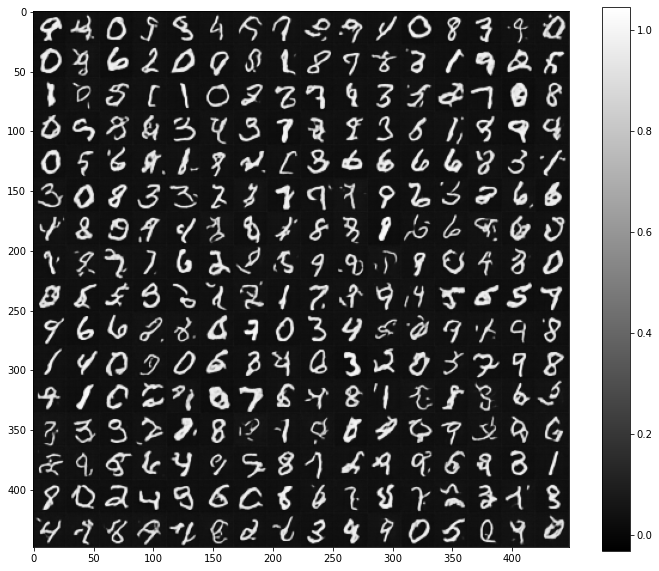

In [25]:
# Fix random seed for reproducible test images
torch.manual_seed(42)
np.random.seed(42)

# # Get fixed test images from test dataset
IMAGE_COUNT = 16 * 16
torch.manual_seed(0)
images_seeds = torch.randn(256, 1, 28, 28).to(device)
    
# Load the trained model
model_path = os.path.join(radius_scan_dir, f'local_model_internal_R{r_test}.pth')

# Create model architecture
test_model = create_local_model(
receptive_field_radius=r_initial,
conv1_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][0],
conv2_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][1],
conv3_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][2],
emb_dim=EMB_DIM,
base_channels=BASE_CHANNELS,
).to(device)

# Load trained weights
checkpoint = torch.load(model_path, map_location=device)
test_model.load_state_dict(checkpoint['model_state_dict'])
test_model.eval()

print(f"Loaded model R{r_test} from {model_path}")

########################
### Phase 0
########################

noisy_images = images_seeds.clone()

########################
### Phase 1
########################

# Global Denoisers
noisy_images = test_partial_global(noisy_images, model_global, gen_with_cond=False, beta_i=t_up, beta_f=1, T=32, IMAGE_COUNT=IMAGE_COUNT)

########################
### Phase 2
########################

# Local Denoisers
noisy_images, _ = euler_generation(test_model, noisy_images, t_up, t_dn, math.ceil((t_up-t_dn)*32))

########################
### Phase 3
########################

# Global Denoisers
noisy_images = test_partial_global(noisy_images, model_global, gen_with_cond=False, beta_i=0, beta_f=t_dn, T=32, IMAGE_COUNT=IMAGE_COUNT)
                
# Convert to 16x16 grid visualization
grid_images = noisy_images[:256].reshape(16, 16, 28, 28).permute(0, 2, 1, 3).reshape(16 * 28, 16 * 28).cpu().numpy()
plt.figure(figsize=(12, 10))
im = plt.imshow(grid_images, cmap='gray')
plt.colorbar(im)

noisy_images_global_local_global = noisy_images.clone()


## 3.3 Local denoisers for $t \in [0, 1]$

<ipython-input-26-6edf3b4655d5>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Creating LOCAL model (R_INTERNAL=0)
Model created: 297,105 parameters
Loaded model R3 from ./model-gen/local_model_internal_R3.pth
Euler Generation: 32 steps with dt=0.0312 from TF=1.00 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:01<00:00, 31.34it/s, TF=0.000, Noise_std=0.288, Img_range=[0.00, 0.95]]


Euler generation completed!


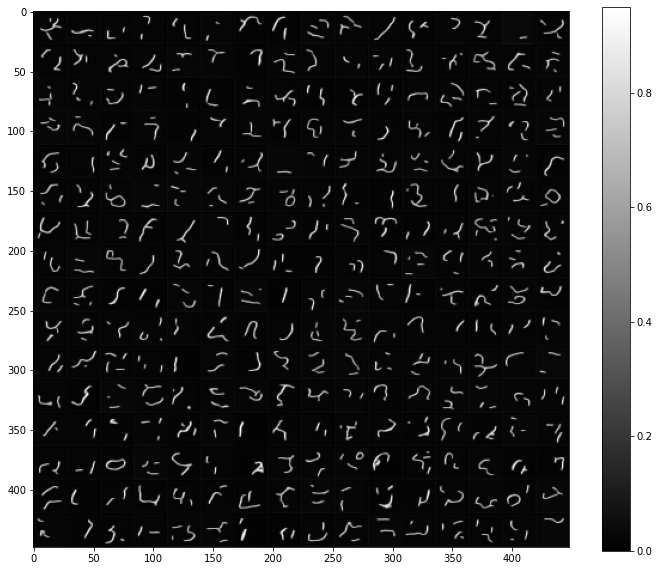

In [26]:
# Fix random seed for reproducible test images
torch.manual_seed(42)
np.random.seed(42)

# # Get fixed test images from test dataset
IMAGE_COUNT = 16 * 16
torch.manual_seed(0)
images_seeds = torch.randn(256, 1, 28, 28).to(device)
    
# Load the trained model
model_path = os.path.join(radius_scan_dir, f'local_model_internal_R{r_test}.pth')

# Create model architecture
test_model = create_local_model(
receptive_field_radius=r_initial,
conv1_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][0],
conv2_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][1],
conv3_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][2],
emb_dim=EMB_DIM,
base_channels=BASE_CHANNELS,
).to(device)

# Load trained weights
checkpoint = torch.load(model_path, map_location=device)
test_model.load_state_dict(checkpoint['model_state_dict'])
test_model.eval()

print(f"Loaded model R{r_test} from {model_path}")

########################
### Phase 0
########################

noisy_images = images_seeds.clone()

########################
### Phase 1
########################

noisy_images, _ = euler_generation(test_model, noisy_images, 1., 0, math.ceil((1-0)*32))

# Convert to 16x16 grid visualization
grid_images = noisy_images[:256].reshape(16, 16, 28, 28).permute(0, 2, 1, 3).reshape(16 * 28, 16 * 28).cpu().numpy()
plt.figure(figsize=(12, 10))
im = plt.imshow(grid_images, cmap='gray')
plt.colorbar(im)

noisy_images_local_local_local = noisy_images.clone()


## 3.4 Global denoisers for $t \in [0, 1]$

Creating LOCAL model (R_INTERNAL=0)
Model created: 297,105 parameters
Loaded model R3 from ./model-gen/local_model_internal_R3.pth
32


<ipython-input-27-f0b14cdf4273>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


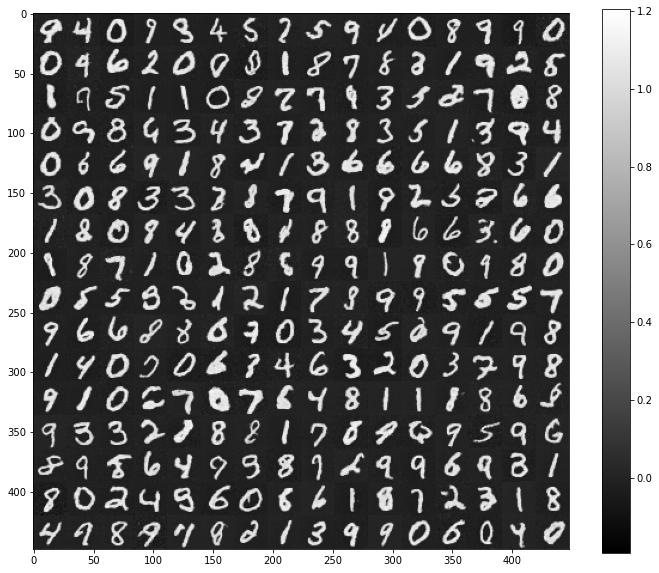

In [27]:
# Fix random seed for reproducible test images
torch.manual_seed(42)
np.random.seed(42)

# # Get fixed test images from test dataset
IMAGE_COUNT = 16 * 16
torch.manual_seed(0)
images_seeds = torch.randn(256, 1, 28, 28).to(device)
    
# Load the trained model
model_path = os.path.join(radius_scan_dir, f'local_model_internal_R{r_test}.pth')

# Create model architecture
test_model = create_local_model(
receptive_field_radius=r_initial,
conv1_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][0],
conv2_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][1],
conv3_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][2],
emb_dim=EMB_DIM,
base_channels=BASE_CHANNELS,
).to(device)

# Load trained weights
checkpoint = torch.load(model_path, map_location=device)
test_model.load_state_dict(checkpoint['model_state_dict'])
test_model.eval()

print(f"Loaded model R{r_test} from {model_path}")

########################
### Phase 0
########################

noisy_images = images_seeds.clone()

########################
### Phase 1
########################

# Global Denoisers
noisy_images = test_partial_global(noisy_images, model_global, gen_with_cond=False, beta_i=0, beta_f=1, T=32, IMAGE_COUNT=IMAGE_COUNT)
                
# Convert to 16x16 grid visualization
grid_images = noisy_images[:256].reshape(16, 16, 28, 28).permute(0, 2, 1, 3).reshape(16 * 28, 16 * 28).cpu().numpy()
plt.figure(figsize=(12, 10))
im = plt.imshow(grid_images, cmap='gray')
plt.colorbar(im)

noisy_images_global_global_global = noisy_images.clone()


# 3.5 Select some examples

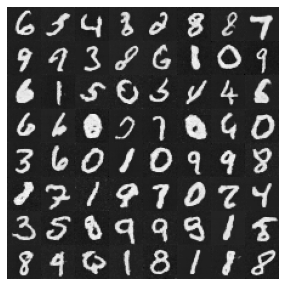

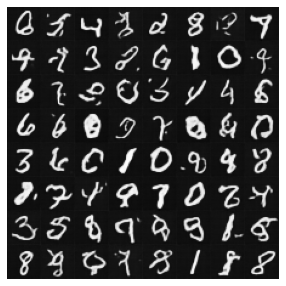

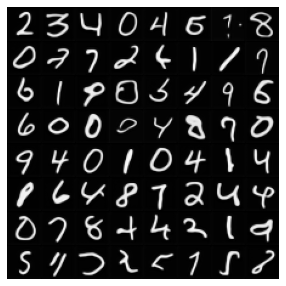

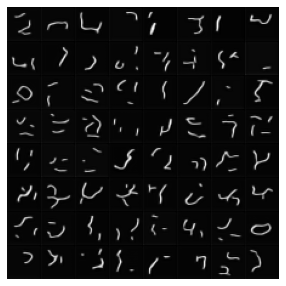

In [30]:
LL = 8

torch.manual_seed(2)
indices = torch.randperm(256)[:LL*LL]

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = axes
grid_images = noisy_images_global_global_global[indices].reshape(LL, LL, 28, 28).permute(0, 2, 1, 3).reshape(LL * 28, LL * 28).cpu().numpy()
ax.imshow(grid_images, cmap='gray')
ax.axis('off')

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = axes
grid_images = noisy_images_global_local_global[indices].reshape(LL, LL, 28, 28).permute(0, 2, 1, 3).reshape(LL * 28, LL * 28).cpu().numpy()
ax.imshow(grid_images, cmap='gray')
ax.axis('off')

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = axes
grid_images = noisy_images_local_global_local[indices].reshape(LL, LL, 28, 28).permute(0, 2, 1, 3).reshape(LL * 28, LL * 28).cpu().numpy()
ax.imshow(grid_images, cmap='gray')
ax.axis('off')

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = axes
grid_images = noisy_images_local_local_local[indices].reshape(LL, LL, 28, 28).permute(0, 2, 1, 3).reshape(LL * 28, LL * 28).cpu().numpy()
ax.imshow(grid_images, cmap='gray')
ax.axis('off')

# plt.tight_layout()
# plt.savefig(os.path.join(heatmap_results_dir, 'mse_heatmap_analysis.png'), 
#             dpi=300, bbox_inches='tight')
plt.show()

In [24]:
# filename = f'./results_local_global/noisy_images_global_global_global.npy'
# np.save(filename, noisy_images_global_global_global.cpu().numpy())

# filename = f'./results_local_global/noisy_images_global_local_global.npy'
# np.save(filename, noisy_images_global_local_global.cpu().numpy())

# filename = f'./results_local_global/noisy_images_local_global_local.npy'
# np.save(filename, noisy_images_local_global_local.cpu().numpy())

# filename = f'./results_local_global/noisy_images_local_local_local.npy'
# np.save(filename, noisy_images_local_local_local.cpu().numpy())